**ASTEROIDES CON PELIGRO POTENCIAL PARA LA TIERRA**
==

Recientemente, la NASA llevó a cabo el primer intento para desviar un asteriode que pudiera suponer un peligro de colisión con la Tierra (https://www.nasa.gov/planetarydefense/dart/).

Utilizando datos procedentes de la NASA (https://ssd.jpl.nasa.gov/tools/sbdb_query.html) intentaremos evaluar mediante modelos de machine learning si es posible predecir si un asteroide es potencialmente peligroso para nuestro planeta.

**1. ANÁLISIS EXPLORATORIO DE LOS DATOS**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score


import warnings
warnings.filterwarnings('ignore', module='sklearn')
warnings.filterwarnings('ignore', module='IPython')

In [2]:
filepath = 'C:/Users/NITROPC/Desktop/DATA SCIENCE/CERTIFICACION MACHINE LEARNING/06 - PROYECTO/dataset.csv'

data = pd.read_csv(filepath, sep = ',')


In [3]:
data.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


A continuación se recoge la descripción básica de las columnas, de acuerdo a lo indicado en la web JPL:
* SPK-ID: Object primary SPK-ID
* Object ID: Object internal database ID
* Object fullname: Object full name/designation
* pdes: Object primary designation
* name: Object IAU name
* NEO: Near-Earth Object (NEO) flag
* PHA: Potentially Hazardous Asteroid (PHA) flag
* H: Absolute magnitude parameter
* Diameter: object diameter (from equivalent sphere) km Unit
* Albedo: Geometric albedo
* Diameter_sigma: 1-sigma uncertainty in object diameter km Unit
* Orbit_id: Orbit solution ID
* Epoch: Epoch of osculation in modified Julian day form
* Equinox: Equinox of reference frame
* e: Eccentricity
* a: Semi-major axis au Unit
* q: perihelion distance au Unit
* i: inclination; angle with respect to x-y ecliptic plane
* tp: Time of perihelion passage TDB Unit
* moid_ld: Earth Minimum Orbit Intersection Distance au Unit

Nuestra variable objetivo es la variable PHA, que indica si un asteriode es potencialmente peligroso o no.

In [4]:
data.shape

(958524, 45)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

Veamos nuestra variable objetivo.

In [6]:
data['pha'].value_counts(normalize=True)

N    0.997799
Y    0.002201
Name: pha, dtype: float64

Como podemos ver, los datos de nuestra variable objetivo están muy poco balanceados.

Veamos cómo se distribuyen los valores dentro de cada una de las variables.

In [7]:
pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
id,958524
spkid,958524
full_name,958524
pdes,958524
name,22065
prefix,2
neo,3
pha,3
H,9490


**2. LIMPIEZA DE DATOS**

Eliminemos algunas columnas que no aportarán ningún tipo de información.

In [8]:
data1 = data.drop(['id','full_name', 'pdes', 'name', 'prefix', 'equinox'], axis='columns', inplace=False)

Veamos a continuación los datos perdidos dentro de nuestra dataframe.

In [9]:
num_missing = data.isnull().sum()
pctg_missing = data.isnull().sum().apply(lambda x: x/data.shape[0]*100)

In [10]:
missing_data = pd.DataFrame({'Number of Missing':  num_missing,
                             'Percentage of Missing': pctg_missing})

missing_data['Percentage of Missing'].sort_values(ascending = False)

prefix            99.998122
name              97.698128
albedo            85.905100
diameter_sigma    85.803068
diameter          85.789714
sigma_ad           2.078821
sigma_per          2.078821
sigma_e            2.078404
sigma_a            2.078404
sigma_q            2.078404
sigma_i            2.078404
sigma_om           2.078404
sigma_w            2.078404
sigma_ma           2.078404
sigma_n            2.078404
sigma_tp           2.078404
pha                2.078300
moid               2.078300
H                  0.653400
moid_ld            0.013250
per                0.000417
ad                 0.000417
neo                0.000417
rms                0.000209
ma                 0.000104
per_y              0.000104
class              0.000000
id                 0.000000
tp_cal             0.000000
equinox            0.000000
full_name          0.000000
pdes               0.000000
orbit_id           0.000000
epoch              0.000000
epoch_mjd          0.000000
epoch_cal          0

Como podemos ver hay cinco variables con valores perdidos por encima del 80%. Estas variables no pueden ser calculadas ni sustituidas, por lo que pueden ser eliminadas.

In [11]:
asteroid_df = data1[data1['pha'].notna()]
asteroid_df = asteroid_df.drop(['diameter', 'albedo', 'diameter_sigma'], axis= 'columns')

In [12]:
asteroid_df = asteroid_df[asteroid_df['H'].notna()]
asteroid_df = asteroid_df[asteroid_df['sigma_ad'].notna()]
asteroid_df = asteroid_df[asteroid_df['ma'].notna()]

In [13]:
asteroid_df.isnull().sum()

spkid        0
neo          0
pha          0
H            0
orbit_id     0
epoch        0
epoch_mjd    0
epoch_cal    0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
class        0
rms          0
dtype: int64

Como podemos ver, ya no tenemos valores nulos en nuestro dataframe.

Algunas columnas presentan valores que no pueden ser procesados dentro de un modelo de machine learning. Estas variables tienen que ser convertidas a variables categóricas.

In [14]:
asteroid_df['neo'] = asteroid_df['neo'].astype('category')
asteroid_df['pha'] = asteroid_df['pha'].astype('category')
asteroid_df['class'] = asteroid_df['class'].astype('category')

In [15]:
orbits = asteroid_df['orbit_id'].value_counts().loc[lambda x: x<10].index.to_list()

In [16]:
asteroid_df.loc[asteroid_df['orbit_id'].isin(orbits), 'orbit_id'] = 'other'

Observemos la correlación entre las distintas variables.

<AxesSubplot:>

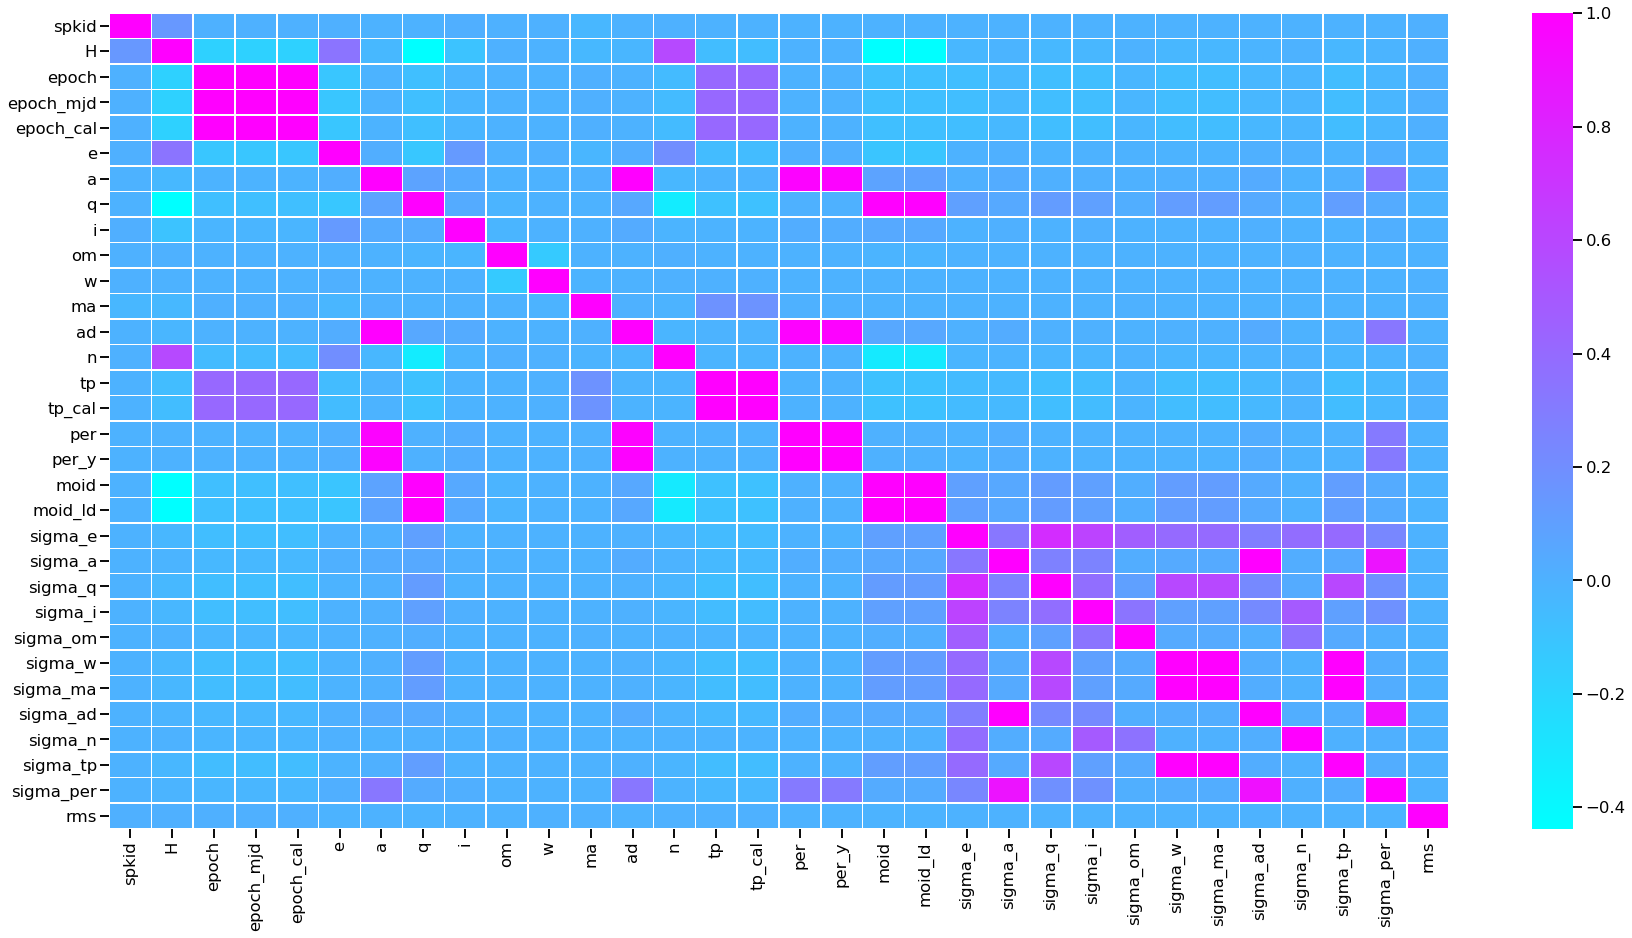

In [61]:
plt.figure(figsize = (30, 15))
sns.heatmap(asteroid_df.corr(), annot = False, linewidths=.5, cmap = plt.cm.cool)

Antes de hecer pasar nuestro dataframe por el modelo, es necesario escalar las variables numéricas. Para ello utilizaremos la función MinMaxScaler.

In [17]:
asteroid_df = asteroid_df.reset_index(drop=True)#Reseteamos el índice

In [18]:
#creamos un subset con las variables numericas
subset_df = asteroid_df[asteroid_df.columns[~asteroid_df.columns.isin(['spkid', 'full_name', 'neo', 'pha', 'orbit_id', 'class'])]]

In [19]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns = subset_df.columns)
asteroid_df = pd.concat([asteroid_df[['spkid', 'neo', 'pha', 'orbit_id', 'class']],scaled_df], axis=1)
scaled_df.head()


,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,om,w,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
0,0.131195,0.988218,0.988218,0.989134,0.076017,0.000066,0.030975,0.060467,0.223071,0.204438,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000161
1,0.154519,1.000000,1.000000,1.000000,0.230004,0.000066,0.025712,0.198916,0.480625,0.861674,...,8.699747e-14,6.262048e-11,5.179478e-12,2.713159e-16,2.650639e-16,8.984495e-16,6.029037e-14,3.912546e-18,1.921434e-16,0.000134
2,0.187464,1.000000,1.000000,1.000000,0.256972,0.000063,0.023805,0.074158,0.471810,0.689073,...,8.016988e-14,5.816901e-11,1.383063e-11,5.285854e-16,2.426430e-16,7.900225e-16,5.717040e-14,3.384558e-18,1.621282e-16,0.000126
3,0.119534,0.988218,0.988218,0.989134,0.088732,0.000054,0.025911,0.040748,0.288363,0.418691,...,1.880819e-15,3.839709e-12,2.721975e-13,3.373713e-18,3.590511e-17,2.972008e-16,3.377845e-14,3.903861e-19,6.623144e-17,0.000149
4,0.233236,1.000000,1.000000,1.000000,0.190939,0.000060,0.025049,0.030614,0.393253,0.996247,...,6.000437e-14,4.945222e-11,2.409083e-11,8.914896e-16,2.484347e-16,8.562875e-16,7.157914e-14,3.332230e-18,1.821889e-16,0.000194


Por último, necesitamos transformar las variables categóricas en variables codificadas. Para ello usaremos la función get_dummies

In [20]:
asteroid_df1 = pd.get_dummies(asteroid_df, columns = ['neo', 'class', 'orbit_id'])
asteroid_df1.head()

,spkid,pha,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,...,orbit_id_JPL 86,orbit_id_JPL 87,orbit_id_JPL 9,orbit_id_JPL 91,orbit_id_JPL 94,orbit_id_JPL 96,orbit_id_JPL 97,orbit_id_JPL 98,orbit_id_JPL 99,orbit_id_other
0,2000001,N,0.131195,0.988218,0.988218,0.989134,0.076017,0.000066,0.030975,0.060467,...,0,0,0,0,0,0,0,0,0,0
1,2000002,N,0.154519,1.000000,1.000000,1.000000,0.230004,0.000066,0.025712,0.198916,...,0,0,0,0,0,0,0,0,0,0
2,2000003,N,0.187464,1.000000,1.000000,1.000000,0.256972,0.000063,0.023805,0.074158,...,0,0,0,0,0,0,0,0,0,1
3,2000004,N,0.119534,0.988218,0.988218,0.989134,0.088732,0.000054,0.025911,0.040748,...,0,0,0,0,0,0,0,0,0,0
4,2000005,N,0.233236,1.000000,1.000000,1.000000,0.190939,0.000060,0.025049,0.030614,...,0,0,0,0,0,0,0,0,0,1


In [21]:
lb = LabelBinarizer()

asteroid_df1['pha'] = lb.fit_transform(asteroid_df1['pha'])

In [22]:
asteroid_df1.head()

,spkid,pha,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,...,orbit_id_JPL 86,orbit_id_JPL 87,orbit_id_JPL 9,orbit_id_JPL 91,orbit_id_JPL 94,orbit_id_JPL 96,orbit_id_JPL 97,orbit_id_JPL 98,orbit_id_JPL 99,orbit_id_other
0,2000001,0,0.131195,0.988218,0.988218,0.989134,0.076017,0.000066,0.030975,0.060467,...,0,0,0,0,0,0,0,0,0,0
1,2000002,0,0.154519,1.000000,1.000000,1.000000,0.230004,0.000066,0.025712,0.198916,...,0,0,0,0,0,0,0,0,0,0
2,2000003,0,0.187464,1.000000,1.000000,1.000000,0.256972,0.000063,0.023805,0.074158,...,0,0,0,0,0,0,0,0,0,1
3,2000004,0,0.119534,0.988218,0.988218,0.989134,0.088732,0.000054,0.025911,0.040748,...,0,0,0,0,0,0,0,0,0,0
4,2000005,0,0.233236,1.000000,1.000000,1.000000,0.190939,0.000060,0.025049,0.030614,...,0,0,0,0,0,0,0,0,0,1


In [23]:
outputfile = 'asteroid_processed.csv'
asteroid_df1.to_csv(outputfile, index=False)

**3. DIVIDIR LOS DATOS**

Antes de preparar nuestros modelos de clasificiación necesitamos dividir nuestros datos en los sets de entrenamiento y prueba. Como nuestro dataframe presenta datos muy sesgados para nuestra variable objetivo, vamos a utilizar la función StratifiedShuffleSplit para mantener la misma proporción de clases.

In [24]:
path = 'C:/Users/NITROPC/Desktop/DATA SCIENCE/CERTIFICACION MACHINE LEARNING/06 - PROYECTO/asteroid_processed.csv'

asteroid_processed = pd.read_csv(path, sep = ',')

In [25]:
feature_cols = list(asteroid_processed.columns)
feature_cols.remove('pha')

In [26]:
X_data = asteroid_processed.drop(['spkid', 'pha'], axis = 1)
y_data = asteroid_processed['pha']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 1501)



In [28]:
X_test.shape

(279701, 240)

In [29]:
y_test.shape

(279701,)

In [30]:
X_train.shape

(652634, 240)

In [31]:
y_train.shape

(652634,)

Dado que nuestros datos presentan un sesgo muy fuerte hacia el No en la variable 'pha' necesitamos que nuestro modelo no sobremuestre la clase positiva. Utilizaremos para ello la libreria SMOTE.

In [32]:
from imblearn.over_sampling import SMOTE

smtn = SMOTE(random_state = 12)

X_train_res, y_train_res = smtn.fit_resample(X_train, y_train)

In [33]:
print("Before OverSampling, counts of label 'N': {}".format(sum(y_train == 0))) 
print("Before OverSampling, counts of label 'Y': {} \n".format(sum(y_train == 1))) 

print("After OverSampling, counts of label 'N': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label 'Y': {}".format(sum(y_train_res == 1))) 

Before OverSampling, counts of label 'N': 651221
Before OverSampling, counts of label 'Y': 1413 

After OverSampling, counts of label 'N': 651221
After OverSampling, counts of label 'Y': 651221


**4. REGRESIÓN LOGISTICA**

Vamos a comenzar nuestros modelos con el modelado por regresión logística.


In [34]:
#creamos el dataframe para nuestras métricas
metrics = pd.DataFrame()

In [35]:
#REgresión logística estandar
lr = LogisticRegression().fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)


Para el modelo vamos a mostrar las métricas asociadas y la matriz de confusión.

In [36]:
precision_lr, recall_lr = (round(float(x),2) for x in list(score(y_test,
                                                                    y_pred_lr,
                                                                    average='weighted'))[:-2])
# adding lr stats to metrics DataFrame
lr_stats = pd.Series({'precision':precision_lr,
                      'recall':recall_lr,
                      'accuracy':round(accuracy_score(y_test, y_pred_lr), 2),
                      'f1score':round(f1_score(y_test, y_pred_lr), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_lr),2)},
                     name='Logistic Regression')
# Report outcomes
pd.DataFrame(classification_report(y_test, y_pred_lr, output_dict=True)).iloc[:3,:2]

,0,1
precision,0.999931,0.208279
recall,0.991363,0.970904
f1-score,0.995629,0.342981


In [37]:
lr_stats

precision    1.00
recall       0.99
accuracy     0.99
f1score      0.34
auc          0.98
Name: Logistic Regression, dtype: float64

Text(0.5, 4.5, 'Ground Truth')

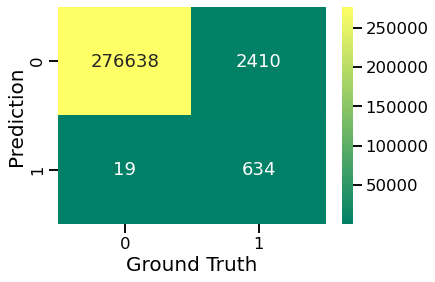

In [38]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_lr)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='summer')  


ax.set_ylabel('Prediction', fontsize=20)
ax.set_xlabel('Ground Truth', fontsize=20)

**5. RANDOM FOREST**

Nuestro siguiente modelo será Random Forest. Este modelo elimina parte de la posibilidad de sobreajuste.

Podríamos analizar el número de árboles iterando entre varios valores y posteriormente graficar el error para conocer con qué valor se estabiliza el error:

    rf = RandomForestClassifier(oob_score = True, warm_start = True, n_jobs = -1, random_state = 1551)

    oob_list = list()

    for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
        rf.set_params(n_estimators = n_trees)
        rf.fit(X_train_res, y_train_res)
    
        oob_error = 1 - rf.oob_score_
        oob_list.append(pd.Series({'n_trees' : n_trees, 'oob' : oob_error}))
    
    rf_oob_df = pd.concat(oob_list, axis = 1).T.set_index('n_trees')

    sns.set_context('talk')
    sns.set_style('white')

    ax = rf_oob_df.plot(legend=False, marker='o', color="green", figsize=(14, 7), linewidth=4)
    ax.set(ylabel='out-of-bag error');
    
Sin embargo, para ahorrar tiempo de procesado, vamos a aplicar un valor de 150 a n_estimators.

In [39]:
rf = RandomForestClassifier(n_estimators = 150, oob_score = True, warm_start = True, n_jobs = -1, random_state = 1551)

In [40]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(n_estimators=150, n_jobs=-1, oob_score=True,
                       random_state=1551, warm_start=True)

In [41]:
y_pred_rf = rf.predict(X_test)

In [42]:
precision_rf, recall_rf = (round(float(x),2) for x in list(score(y_test,
                                                                    y_pred_rf,
                                                                    average='weighted'))[:-2])
rf_stats = pd.Series({'precision':precision_rf,
                      'recall':recall_rf,
                      'accuracy':round(accuracy_score(y_test, y_pred_rf), 2),
                      'f1score':round(f1_score(y_test, y_pred_rf), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_rf),2)}, name='Random Forest')

pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).iloc[:3,:2]

,0,1
precision,0.999968,0.947059
recall,0.999871,0.986217
f1-score,0.999919,0.966242


In [43]:
rf_stats

precision    1.00
recall       1.00
accuracy     1.00
f1score      0.97
auc          0.99
Name: Random Forest, dtype: float64

Text(0.5, 4.5, 'Ground Truth')

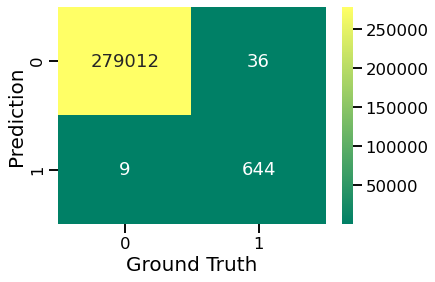

In [44]:
sns.set_context('talk')
cm_rf = confusion_matrix(y_test, y_pred_rf)
ax = sns.heatmap(cm_rf, annot=True, fmt='d', cmap='summer')  


ax.set_ylabel('Prediction', fontsize=20)
ax.set_xlabel('Ground Truth', fontsize=20)

**6.POTENCIADOR DE GRADIENTE**

Por último vamos a aplicar un modelo de potenciador de gradiente. Esta técnica combina los principios de la potenciación de gradiente con la aletoriedad de los árboles de decisión. 

In [48]:
from sklearn.ensemble import GradientBoostingClassifier


Al igual que en el modelo Random Forest podríamos analizar el número de árboles iterando entre varios valores y posteriormente graficar el error para conocer con qué valor se estabiliza:
    
    error_list = list()

    tree_list = [15, 25, 50, 100, 200, 400]
    for n_trees in tree_list:
    
        GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

        print(f'Fitting model with {n_trees} trees')
        GBC.fit(X_train_res.values, y_train_res.values)
        y_pred = GBC.predict(X_test)

        error = 1.0 - accuracy_score(y_test, y_pred)
        Store it
        error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

    error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

    error_df
  
Para ahorrar tiempo de procesado, vamos a aplicar un valor de 150 a n_estimators.

In [49]:
gbc = GradientBoostingClassifier(n_estimators = 400, learning_rate = 0.1, subsample = 0.5, max_features = 4, warm_start = False)

In [50]:
gbc.fit(X_train_res, y_train_res)

GradientBoostingClassifier(max_features=4, n_estimators=400, subsample=0.5)

In [51]:
y_pred_gbc = gbc.predict(X_test)

In [57]:
precision_gbc, recall_gbc = (round(float(x),2) for x in list(score(y_test,
                                                                    y_pred_rf,
                                                                    average='weighted'))[:-2])
gbc_stats = pd.Series({'precision':precision_gbc,
                      'recall':recall_rf,
                      'accuracy':round(accuracy_score(y_test, y_pred_gbc), 2),
                      'f1score':round(f1_score(y_test, y_pred_gbc), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_gbc),2)}, name='Random Forest')

pd.DataFrame(classification_report(y_test, y_pred_gbc, output_dict=True)).iloc[:3,:2]

,0,1
precision,0.999989,0.705755
recall,0.999029,0.995406
f1-score,0.999509,0.825921


In [58]:
gbc_stats

precision    1.00
recall       1.00
accuracy     1.00
f1score      0.83
auc          1.00
Name: Random Forest, dtype: float64

Text(0.5, 4.5, 'Ground Truth')

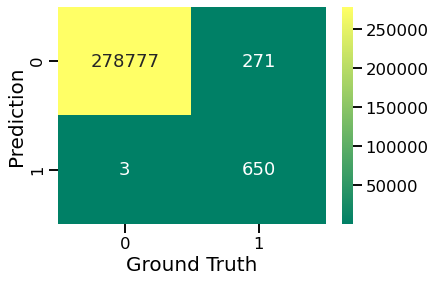

In [55]:
sns.set_context('talk')
cm_rf = confusion_matrix(y_test, y_pred_gbc)
ax = sns.heatmap(cm_rf, annot=True, fmt='d', cmap='summer')  


ax.set_ylabel('Prediction', fontsize=20)
ax.set_xlabel('Ground Truth', fontsize=20)

**7. CONCLUSIONES**

A continuación se resumen las métricas para cada uno de los modelos aplicados:

In [59]:
metrics.append([lr_stats, rf_stats, gbc_stats])

,precision,recall,accuracy,f1score,auc
Logistic Regression,1.0,0.99,0.99,0.34,0.98
Random Forest,1.0,1.00,1.00,0.83,1.00
Random Forest,1.0,1.00,1.00,0.83,1.00


Todos los modelos presentan unos valores similares. Sin embargo, dada la naturaleza sesgada de los datos, se hace necesario el uso de algoritmos de potenciamiento y validadción cruzada, que suponen un mayor tiempo de procesado.